# Output Analysis

This notebook contains the basic result analysis.

Before running this notebook, run `preload-train-ratings-balanced.R` to prepare intermediate data files.

## Setup

Libraries:

In [1]:
library(MASS)
library(dplyr)
library(readr)
library(ggplot2)
library(tidyr)
library(modelr)
library(tibble)


Attaching package: ‘dplyr’

The following object is masked from ‘package:MASS’:

    select

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Options:

In [2]:
options(repr.plot.height=5)
options(repr.matrix.max.rows=10)
options(repr.matrix.max.columns=10)

Utilities:

In [3]:
source("plot-tools.R")

### Demographic Utilities

We need to be able to normalize ages.

In [4]:
ml_age_bins = c("1"="1-17", "18"="18-24", "25"="25-34", "35"="35-44", "45"="45-49", "50"="50-55", "56"="56+")
ml_age_lbs = c(1, 18, 25, 35, 45, 50, 56)

Function to bound numeric ages:

In [5]:
bound_ages = function(ages, bounds=ml_age_lbs) {
    ages[ages <= 0] = NA
    selectors = rowSums(outer(ages, ml_age_lbs, ">="))
    factor(ml_age_bins[selectors], levels=ml_age_bins, ordered=TRUE)
}

Function to rename MovieLens age lower bounds:

In [6]:
rename_ages = function(ages) {
    stopifnot(is.character(ages))
    factor(ml_age_bins[ages], levels=ml_age_bins, ordered=TRUE)
}

## Read Data

### User Data

First, we need to read the user data from the underlying MovieLens data:

user info can be same as unbalanced data.

In [7]:
users.meta.ml = read_delim("data/ml-1m/users.dat", delim=":",
                   col_names=c("user", "gender", "age", "occupation", "zip"),
                   col_types="i_c_c_c_c") %>%
    mutate(gender=as.factor(gender),
           age=rename_ages(age),
           occupation=as.factor(occupation))
users.meta.ml

user,gender,age,occupation,zip
1,F,1-17,10,48067
2,M,56+,16,70072
3,M,25-34,15,55117
4,M,45-49,7,02460
5,M,25-34,20,55455
⋮,⋮,⋮,⋮,⋮
6036,F,25-34,15,32603
6037,F,45-49,1,76006
6038,F,56+,1,14706
6039,F,45-49,0,01060


Do the same thing with Last.FM:

In [8]:
users.meta.360k = read_csv("build/lastfm-users.csv") %>%
    mutate(gender=as.factor(toupper(gender)),
           age=bound_ages(if_else(age > 0, age, as.integer(NA)))) %>%
    select(user=id, gender, age)

users.meta.360k

Parsed with column specification:
cols(
  id = col_integer(),
  key = col_character(),
  gender = col_character(),
  age = col_integer()
)


user,gender,age
1,F,18-24
2,F,NA
3,NA,NA
4,M,18-24
5,M,25-34
⋮,⋮,⋮
359343,M,25-34
359344,M,25-34
359345,M,18-24
359346,M,18-24


Merge together the metadata.

In [9]:
users.meta = 
    bind_rows(ML1M.GB=users.meta.ml,
              LFM360K.GB=users.meta.360k,
              .id="DataSet")
users.meta

DataSet,user,gender,age,occupation,zip
ML1M.GB,1,F,1-17,10,48067
ML1M.GB,2,M,56+,16,70072
ML1M.GB,3,M,25-34,15,55117
ML1M.GB,4,M,45-49,7,02460
ML1M.GB,5,M,25-34,20,55455
⋮,⋮,⋮,⋮,⋮,⋮
LFM360K.GB,359343,M,25-34,NA,NA
LFM360K.GB,359344,M,25-34,NA,NA
LFM360K.GB,359345,M,18-24,NA,NA
LFM360K.GB,359346,M,18-24,NA,NA


### User Profile Statistics

Now, we want to get user profile statistics. In order to do that, we need each user's train profile; we can load that from the training data output by the cross-folding process.  The `preload-train-ratings.R` script pre-processes that data so we don't have to spend as much time doing it here.

For each partition, we loaded the _train ratings_ (historical profile) for all the _test users_ in that partition. So we will load the test data (to get the users) and the train data (to get the histories), then merge them.

In [10]:
load("build/ml1m-train-balanced.Rdata")
ml1m.train.ratings

user,part,item,rating,timestamp
4100,1,3082,4,965414364
4100,1,3643,4,965414390
4100,1,1587,4,965414364
4100,1,2949,4,965414340
4100,1,3763,4,965414073
⋮,⋮,⋮,⋮,⋮
4077,5,1391,3,965446817
4077,5,2971,5,965449862
4077,5,2006,4,965445356
4077,5,2640,5,965444052


In [11]:
load("build/lfm360k-train-balanced.Rdata")
lfm360k.train.counts

user,part,item,count
112429,1,2130,491
112429,1,1277,199
112429,1,7930,196
112429,1,2256,164
112429,1,12770,156
⋮,⋮,⋮,⋮
279454,5,1484,26
279454,5,798,26
279454,5,2255,25
279454,5,159,25


Now we want to compute per-user profile statistics.

In [12]:
ml.user.stats = ml1m.train.ratings %>%
    group_by(user) %>%
    summarize(nitems = n(), meanRating=mean(rating), ratingVar=var(rating))
ml.user.stats

user,nitems,meanRating,ratingVar
1,48,4.187500,0.4534574
4,16,4.187500,1.0958333
5,193,3.124352,1.2865393
6,66,3.909091,0.6993007
8,134,3.858209,0.8594434
⋮,⋮,⋮,⋮
6031,46,3.760870,1.9637681
6035,275,2.607273,2.2904579
6038,15,3.866667,0.8380952
6039,118,3.889831,0.5433145


In [13]:
lfm360k.user.stats = lfm360k.train.counts %>%
    group_by(user) %>%
    summarize(nitems=n(), medCount=median(count))
lfm360k.user.stats

user,nitems,medCount
1,44,230.0
9,44,4.0
16,42,319.5
46,57,180.0
60,43,198.0
⋮,⋮,⋮
359275,45,769
359311,40,12
359312,49,96
359321,42,140


In [14]:
user.stats =
    bind_rows(ML1M.GB=ml.user.stats,
              LFM360K.GB=lfm360k.user.stats,
              .id="DataSet") %>%
    select(DataSet, user, nitems)
user.stats

DataSet,user,nitems
ML1M.GB,1,48
ML1M.GB,4,16
ML1M.GB,5,193
ML1M.GB,6,66
ML1M.GB,8,134
⋮,⋮,⋮
LFM360K.GB,359275,45
LFM360K.GB,359311,40
LFM360K.GB,359312,49
LFM360K.GB,359321,42


Join these statistics with our user metadata table, so that we have one table of user information:

In [15]:
users = users.meta %>% inner_join(user.stats)
users

Joining, by = c("DataSet", "user")


DataSet,user,gender,age,occupation,zip,nitems
ML1M.GB,1,F,1-17,10,48067,48
ML1M.GB,4,M,45-49,7,02460,16
ML1M.GB,5,M,25-34,20,55455,193
ML1M.GB,6,F,50-55,9,55117,66
ML1M.GB,8,M,25-34,12,11413,134
⋮,⋮,⋮,⋮,⋮,⋮,⋮
LFM360K.GB,359275,F,NA,NA,NA,45
LFM360K.GB,359311,M,35-44,NA,NA,40
LFM360K.GB,359312,M,18-24,NA,NA,49
LFM360K.GB,359321,F,25-34,NA,NA,42


Now that we have user information, we can read the per-user recommender evaluation results.

In [16]:
ml.user.results = read_csv("build/movielens-user-results.csv", guess_max=10000) %>%
    rename(user=User) %>%
    filter(DataSet == "ML-1M.GB") %>%
    mutate(DataSet = "ML1M.GB")
ml.user.results

Parsed with column specification:
cols(
  .default = col_double(),
  DataSet = col_character(),
  Partition = col_integer(),
  Algorithm = col_character(),
  User = col_integer(),
  L100.Rank = col_integer(),
  Rank = col_integer(),
  `1R.nDCG` = col_character(),
  `1R.Rank` = col_character(),
  `1R.RecipRank` = col_character(),
  `1R.AvgPrec` = col_character()
)
See spec(...) for full column specifications.


DataSet,Partition,Algorithm,user,TestTime,RMSE,Rank.nDCG,L100.nDCG,L100.Rank,L100.RecipRank,L100.AvgPrec,TopN.ActualLength,nDCG,Rank,RecipRank,AvgPrec,1R.nDCG,1R.Rank,1R.RecipRank,1R.AvgPrec
ML1M.GB,5,UU-E,4077,2.166,0.5989862,0.9908541,0.06519129,41,0.02439024,0.02439024,3661,0.1678840,41,0.024390244,0.008420578,NA,NA,NA,NA
ML1M.GB,5,UU-E,4103,1.950,1.2600390,0.9702170,0.00000000,NA,0.00000000,0.00000000,3742,0.1295478,511,0.001956947,0.002338448,NA,NA,NA,NA
ML1M.GB,5,UU-E,4109,1.723,0.8923990,0.9416146,0.05619730,63,0.01587302,0.01587302,3863,0.1611585,63,0.015873016,0.008224152,NA,NA,NA,NA
ML1M.GB,5,UU-E,4119,1.820,1.0580385,0.9256552,0.00000000,NA,0.00000000,0.00000000,3834,0.1438356,241,0.004149378,0.004885170,NA,NA,NA,NA
ML1M.GB,5,UU-E,4134,1.950,0.8821956,0.9497345,0.00000000,NA,0.00000000,0.00000000,3770,0.1430856,349,0.002865330,0.004775088,NA,NA,NA,NA
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
ML1M.GB,1,UU-B,3249,1.884,NA,0.9956168,0.16472759,7,0.14285714,0.08635394,3528,0.2527621,7,0.14285714,0.04479539,NA,NA,NA,NA
ML1M.GB,1,UU-B,3086,1.788,NA,1.0000000,0.08470706,98,0.01020408,0.01510204,3480,0.1817967,98,0.01020408,0.01203531,NA,NA,NA,NA
ML1M.GB,1,UU-B,3263,1.936,NA,0.9568941,0.61389900,1,1.00000000,0.63048246,3481,0.6557103,1,1.00000000,0.50810344,NA,NA,NA,NA
ML1M.GB,1,UU-B,3093,1.883,NA,1.0000000,0.16338324,11,0.09090909,0.07771261,3413,0.2288709,11,0.09090909,0.03488816,NA,NA,NA,NA


In [17]:
lfm360k.user.results = read_csv("build/lastfm-balanced-user-results.csv", guess_max=10000) %>%
    rename(user=User) %>%
    filter(!startsWith(Algorithm, "UU-")) %>%
    mutate(DataSet = "LFM360K.GB")
lfm360k.user.results

Parsed with column specification:
cols(
  .default = col_double(),
  DataSet = col_character(),
  Partition = col_integer(),
  Algorithm = col_character(),
  User = col_integer(),
  L100.Rank = col_integer(),
  L10K.Rank = col_integer(),
  Rank = col_integer()
)
See spec(...) for full column specifications.


DataSet,Partition,Algorithm,user,TestTime,Rank.nDCG,L100.Rank,L100.RecipRank,L100.nDCG,L100.AvgPrec,L10K.TopN.ActualLength,L10K.Rank,L10K.RecipRank,L10K.nDCG,L10K.AvgPrec,TopN.ActualLength,Rank,RecipRank,nDCG,AvgPrec
LFM360K.GB,3,Pop-B,238351,2.161,0.8743048,63,0.01587302,0.07035068,0.01892552,10000,63,0.015873016,0.1625313,0.013385420,125192,63,0.015873016,0.1625313,0.013385420
LFM360K.GB,5,Pop-B,241257,2.169,0.9691688,5,0.20000000,0.26341645,0.09904762,10000,5,0.200000000,0.3035794,0.066905821,125217,5,0.200000000,0.3035794,0.066905821
LFM360K.GB,4,Pop-B,236288,0.278,0.9203801,NA,0.00000000,0.00000000,0.00000000,10000,269,0.003717472,0.1210761,0.002147099,125209,269,0.003717472,0.1210761,0.002147099
LFM360K.GB,3,Pop-C,238351,0.121,0.8743048,54,0.01851852,0.04212012,0.01851852,10000,54,0.018518519,0.1587746,0.011256772,125192,54,0.018518519,0.1587746,0.011256772
LFM360K.GB,5,Pop-C,241257,0.122,0.9691688,6,0.16666667,0.29079045,0.09782138,10000,6,0.166666667,0.3086040,0.081568363,125217,6,0.166666667,0.3086040,0.081568363
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
LFM360K.GB,1,II-B,2454,0.878,0.9786268,1,1.0000000,0.46868978,0.40211640,10000,1,1.0000000,0.5184497,0.24517077,53192,1,1.0000000,0.5184497,0.24517077
LFM360K.GB,1,II-B,44667,0.833,0.7707650,3,0.3333333,0.23238157,0.20693976,10000,3,0.3333333,0.2888432,0.16810283,83735,3,0.3333333,0.2888432,0.16810283
LFM360K.GB,1,II-B,35706,0.808,0.6387630,10,0.1000000,0.04326819,0.06315789,10000,10,0.1000000,0.1510542,0.03651757,42826,10,0.1000000,0.1510542,0.03651757
LFM360K.GB,1,II-B,11621,0.812,0.9861884,1,1.0000000,0.48606784,0.32137083,10000,1,1.0000000,0.5055259,0.25811086,46332,1,1.0000000,0.5055259,0.25811086


In [18]:
user.results = 
    bind_rows(ml.user.results, lfm360k.user.results) %>%
    inner_join(users)
user.results

Joining, by = c("DataSet", "user")


DataSet,Partition,Algorithm,user,TestTime,RMSE,Rank.nDCG,L100.nDCG,L100.Rank,L100.RecipRank,⋯,L10K.TopN.ActualLength,L10K.Rank,L10K.RecipRank,L10K.nDCG,L10K.AvgPrec,gender,age,occupation,zip,nitems
ML1M.GB,5,UU-E,4077,2.166,0.5989862,0.9908541,0.06519129,41,0.02439024,⋯,NA,NA,NA,NA,NA,F,35-44,2,22030,222
ML1M.GB,5,UU-E,4103,1.950,1.2600390,0.9702170,0.00000000,NA,0.00000000,⋯,NA,NA,NA,NA,NA,M,18-24,16,11211,141
ML1M.GB,5,UU-E,4109,1.723,0.8923990,0.9416146,0.05619730,63,0.01587302,⋯,NA,NA,NA,NA,NA,M,35-44,3,97202,20
ML1M.GB,5,UU-E,4119,1.820,1.0580385,0.9256552,0.00000000,NA,0.00000000,⋯,NA,NA,NA,NA,NA,M,50-55,1,39401,49
ML1M.GB,5,UU-E,4134,1.950,0.8821956,0.9497345,0.00000000,NA,0.00000000,⋯,NA,NA,NA,NA,NA,F,45-49,12,85283,113
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
LFM360K.GB,1,II-B,2454,0.878,NA,0.9786268,0.46868978,1,1.0000000,⋯,10000,1,1.0000000,0.5184497,0.24517077,M,18-24,NA,NA,54
LFM360K.GB,1,II-B,44667,0.833,NA,0.7707650,0.23238157,3,0.3333333,⋯,10000,3,0.3333333,0.2888432,0.16810283,M,18-24,NA,NA,58
LFM360K.GB,1,II-B,35706,0.808,NA,0.6387630,0.04326819,10,0.1000000,⋯,10000,10,0.1000000,0.1510542,0.03651757,M,18-24,NA,NA,42
LFM360K.GB,1,II-B,11621,0.812,NA,0.9861884,0.48606784,1,1.0000000,⋯,10000,1,1.0000000,0.5055259,0.25811086,F,18-24,NA,NA,43


In [19]:
write_csv(user.results, "build/integrated-user-results-balanced.csv")

In [20]:
overall.results = user.results %>%
    select(DataSet, Algorithm, RecipRank, nDCG, Rank.nDCG) %>%
    group_by(DataSet, Algorithm) %>%
    summarize(nDCG=mean(nDCG), MRR=mean(RecipRank), Rank.nDCG=mean(Rank.nDCG)) %>%
    ungroup()

In [21]:
best.algos = overall.results %>%
    group_by(DataSet) %>%
    summarize(BestNDCG=max(nDCG),
              BestAlgo=Algorithm[which.max(nDCG)])
best.algos

DataSet,BestNDCG,BestAlgo
LFM360K.GB,0.2976651,II-CS
ML1M.GB,0.3389445,UU-B


In [22]:
best.results = best.algos %>%
    select(DataSet, BestAlgo) %>%
    inner_join(user.results) %>%
    filter(Algorithm == BestAlgo) %>%
    select(-BestAlgo)
best.results

Joining, by = "DataSet"


DataSet,Partition,Algorithm,user,TestTime,RMSE,Rank.nDCG,L100.nDCG,L100.Rank,L100.RecipRank,⋯,L10K.TopN.ActualLength,L10K.Rank,L10K.RecipRank,L10K.nDCG,L10K.AvgPrec,gender,age,occupation,zip,nitems
LFM360K.GB,5,II-CS,241257,0.984,NA,1.0000000,0.8843862,1,1.00000000,⋯,10000,1,1.00000000,0.9042851,0.629553508,F,18-24,NA,NA,47
LFM360K.GB,5,II-CS,241379,0.928,NA,0.9998046,0.6155227,2,0.50000000,⋯,10000,2,0.50000000,0.6284422,0.277707892,M,25-34,NA,NA,43
LFM360K.GB,5,II-CS,241418,1.257,NA,1.0000000,0.0732648,98,0.01020408,⋯,10000,98,0.01020408,0.1594662,0.007873021,M,25-34,NA,NA,49
LFM360K.GB,5,II-CS,241591,0.924,NA,0.9775495,0.4665744,2,0.50000000,⋯,10000,2,0.50000000,0.4867976,0.135500106,M,18-24,NA,NA,46
LFM360K.GB,1,II-CS,238747,0.891,NA,0.9617225,0.1880519,2,0.50000000,⋯,10000,2,0.50000000,0.2167042,0.117434520,M,25-34,NA,NA,35
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
ML1M.GB,1,UU-B,3249,1.884,NA,0.9956168,0.16472759,7,0.14285714,⋯,NA,NA,NA,NA,NA,F,25-34,4,92648,60
ML1M.GB,1,UU-B,3086,1.788,NA,1.0000000,0.08470706,98,0.01020408,⋯,NA,NA,NA,NA,NA,M,18-24,12,98105,108
ML1M.GB,1,UU-B,3263,1.936,NA,0.9568941,0.61389900,1,1.00000000,⋯,NA,NA,NA,NA,NA,M,50-55,11,66048,108
ML1M.GB,1,UU-B,3093,1.883,NA,1.0000000,0.16338324,11,0.09090909,⋯,NA,NA,NA,NA,NA,F,45-49,20,89134,174


## Gender

Let's analyze accuracy by gender.

In [23]:
gender.results = user.results %>%
    select(DataSet, Algorithm, gender, RecipRank, nDCG, Rank.nDCG) %>%
    group_by(DataSet, Algorithm, gender) %>%
    summarize(nDCG=mean(nDCG), Rank.nDCG=mean(Rank.nDCG), MRR=mean(RecipRank)) %>%
    ungroup()
head(gender.results)

DataSet,Algorithm,gender,nDCG,Rank.nDCG,MRR
LFM360K.GB,II-B,F,0.29524594,0.8908668,0.294032645
LFM360K.GB,II-B,M,0.29684951,0.8918202,0.301677861
LFM360K.GB,II-C,F,0.08977526,0.8831727,0.001039092
LFM360K.GB,II-C,M,0.09027137,0.8849393,0.001313784
LFM360K.GB,II-CS,F,0.29668966,0.8918097,0.294232913
LFM360K.GB,II-CS,M,0.29864882,0.8926383,0.303016296


In [24]:
combined.results = bind_rows(gender.results,
                             overall.results %>% mutate(gender = 'Any')) %>%
    inner_join(best.algos %>% select(DataSet, BestAlgo)) %>%
    mutate(IsBest = Algorithm == BestAlgo)
head(combined.results)

Warning message in bind_rows_(x, .id):
“binding factor and character vector, coercing into character vector”Joining, by = "DataSet"


DataSet,Algorithm,gender,nDCG,Rank.nDCG,MRR,BestAlgo,IsBest
LFM360K.GB,II-B,F,0.29524594,0.8908668,0.294032645,II-CS,FALSE
LFM360K.GB,II-B,M,0.29684951,0.8918202,0.301677861,II-CS,FALSE
LFM360K.GB,II-C,F,0.08977526,0.8831727,0.001039092,II-CS,FALSE
LFM360K.GB,II-C,M,0.09027137,0.8849393,0.001313784,II-CS,FALSE
LFM360K.GB,II-CS,F,0.29668966,0.8918097,0.294232913,II-CS,TRUE
LFM360K.GB,II-CS,M,0.29864882,0.8926383,0.303016296,II-CS,TRUE


What does the nDCG look like?

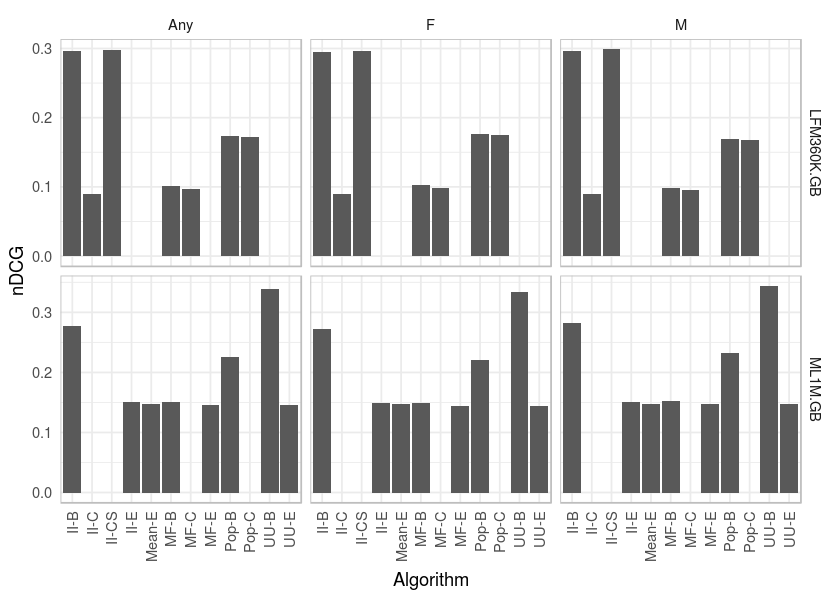

In [25]:
ggplot(combined.results) +
    aes(x=Algorithm, y=nDCG) +
    geom_bar(stat="identity") +
    facet_grid(DataSet ~ gender, scales="free") +
    theme_paper() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5))

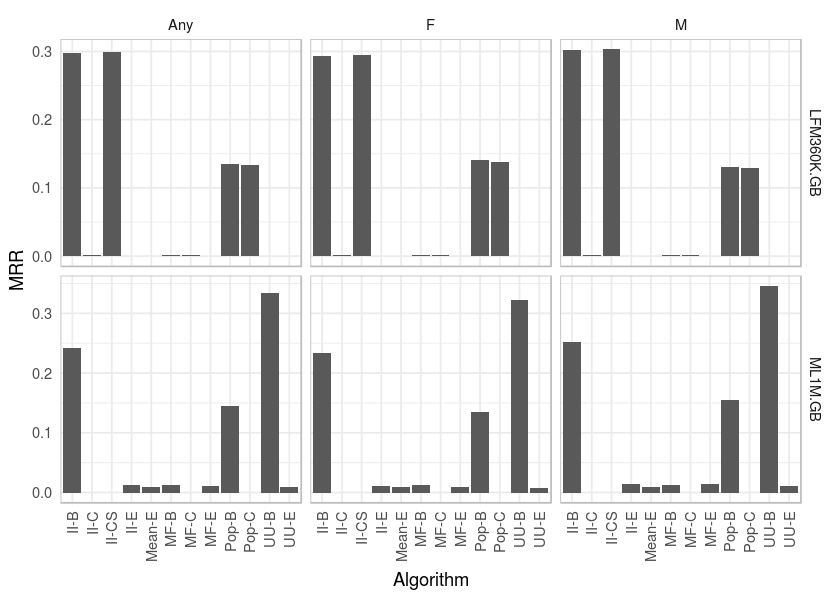

In [26]:
ggplot(combined.results) +
    aes(x=Algorithm, y=MRR) +
    geom_bar(stat="identity") +
    facet_grid(DataSet ~ gender, scales="free") +
    theme_paper() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5))

For the paper, we need to split the nDCG plots into separate MovieLens and Last.FM charts.

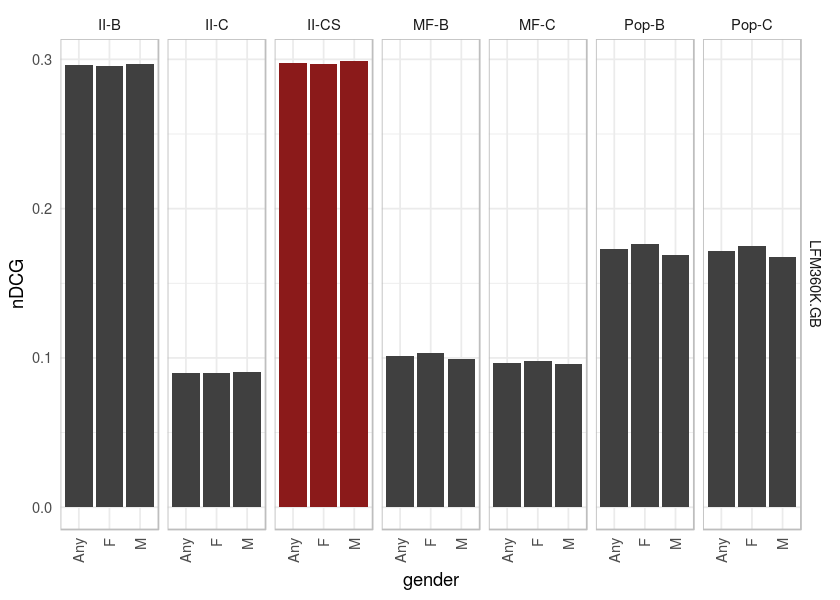

In [31]:
make.plot("balanced-gender-ndcg-lfm", width=5.5, height=1.9, {
    ggplot(combined.results %>% filter(startsWith(DataSet, "LFM"))) +
        aes(x=gender, y=nDCG, fill=IsBest) +
        geom_bar(stat="identity") +
        facet_grid(DataSet ~ Algorithm, scales="free") +
        scale_fill_manual(values=c("grey25", "firebrick4")) +
        guides(fill=FALSE) +
        theme_paper() +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5))
})

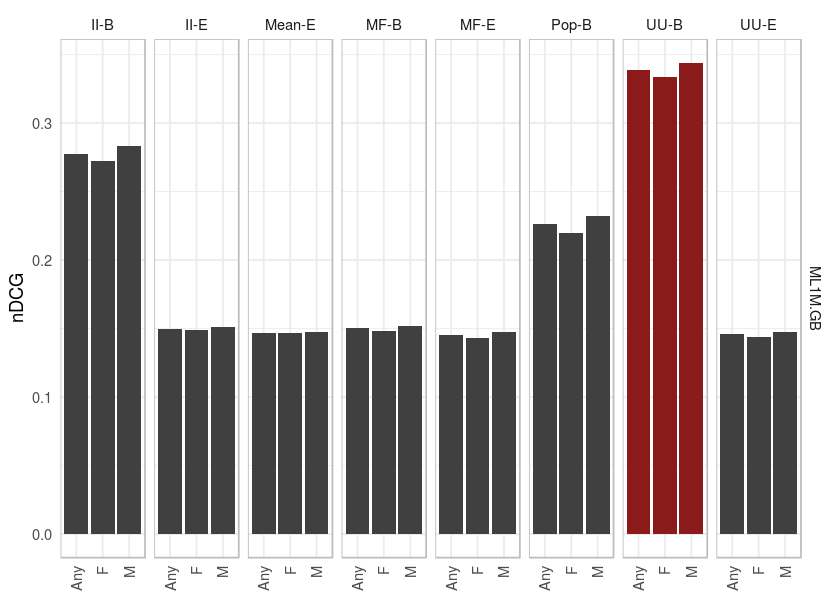

In [28]:
make.plot("balanced-gender-ndcg-ml", width=5.5, height=1.9, {
    ggplot(combined.results %>% filter(startsWith(DataSet, "ML"))) +
        aes(x=gender, y=nDCG, fill=IsBest) +
        geom_bar(stat="identity") +
        facet_grid(DataSet ~ Algorithm, scales="free") +
        scale_fill_manual(values=c("grey25", "firebrick4")) +
        guides(fill=FALSE) +
        xlab(NULL) +
        theme_paper() +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5))
})

Kruskal-Wallis test

In [29]:
kruskal.test(nDCG ~ gender, filter(best.results, DataSet == "ML1M.GB"))


	Kruskal-Wallis rank sum test

data:  nDCG by gender
Kruskal-Wallis chi-squared = 3.6614, df = 1, p-value = 0.05569


In [30]:
kruskal.test(nDCG ~ gender, filter(best.results, DataSet == "LFM360K.GB"))


	Kruskal-Wallis rank sum test

data:  nDCG by gender
Kruskal-Wallis chi-squared = 0.13351, df = 1, p-value = 0.7148
